# Project 3 - Behavioral Cloning

In [1]:
# imports
import os
import pickle
import json
import random
import csv


import cv2
import numpy as np
import os
import csv
import glob

import pandas as pd
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from sklearn.model_selection import train_test_split

## Data Discovery and Analysis

### Data Discovery

In [2]:
data_dir = 'data2/'
logs = glob.glob(data_dir+'*.csv')

# logs = [ 'data2/driving_log_udacity.csv', 'data2/driving_log_recovery_march112017.csv']
logs = [ 'data2/driving_log_udacity.csv']

print(logs)


['data2/driving_log_udacity.csv']


In [3]:
# load training data
frames = []
for f in logs:
    df_tmp = pd.read_csv(f, header=0)
    df_tmp.columns = ["center_image", "left_image", "right_image", "steering_angle", "throttle", "break", "speed"]
    print('log: ', f)
    print('len: ', len(df_tmp))
    frames.append(df_tmp)

# print(frames[3].tail())
df = pd.concat(frames,ignore_index=True)
print('total len: ', len(df))
# df
# # df.head()
# df.index
# df.columns
# df.values
# df.describe()
# df.dtypes
df.tail(3)

log:  data2/driving_log_udacity.csv
len:  8035
total len:  8035


center_image  \
8032  IMG/center_2016_12_01_13_46_38_846.jpg   
8033  IMG/center_2016_12_01_13_46_38_922.jpg   
8034  IMG/center_2016_12_01_13_46_38_947.jpg   

                                left_image  \
8032  IMG/left_2016_12_01_13_46_38_846.jpg   
8033  IMG/left_2016_12_01_13_46_38_922.jpg   
8034  IMG/left_2016_12_01_13_46_38_947.jpg   

                                right_image  steering_angle  throttle  break  \
8032  IMG/right_2016_12_01_13_46_38_846.jpg             0.0       0.0    0.0   
8033  IMG/right_2016_12_01_13_46_38_922.jpg             0.0       0.0    0.0   
8034  IMG/right_2016_12_01_13_46_38_947.jpg             0.0       0.0    0.0   

         speed  
8032  1.388364  
8033  1.377208  
8034  1.374433

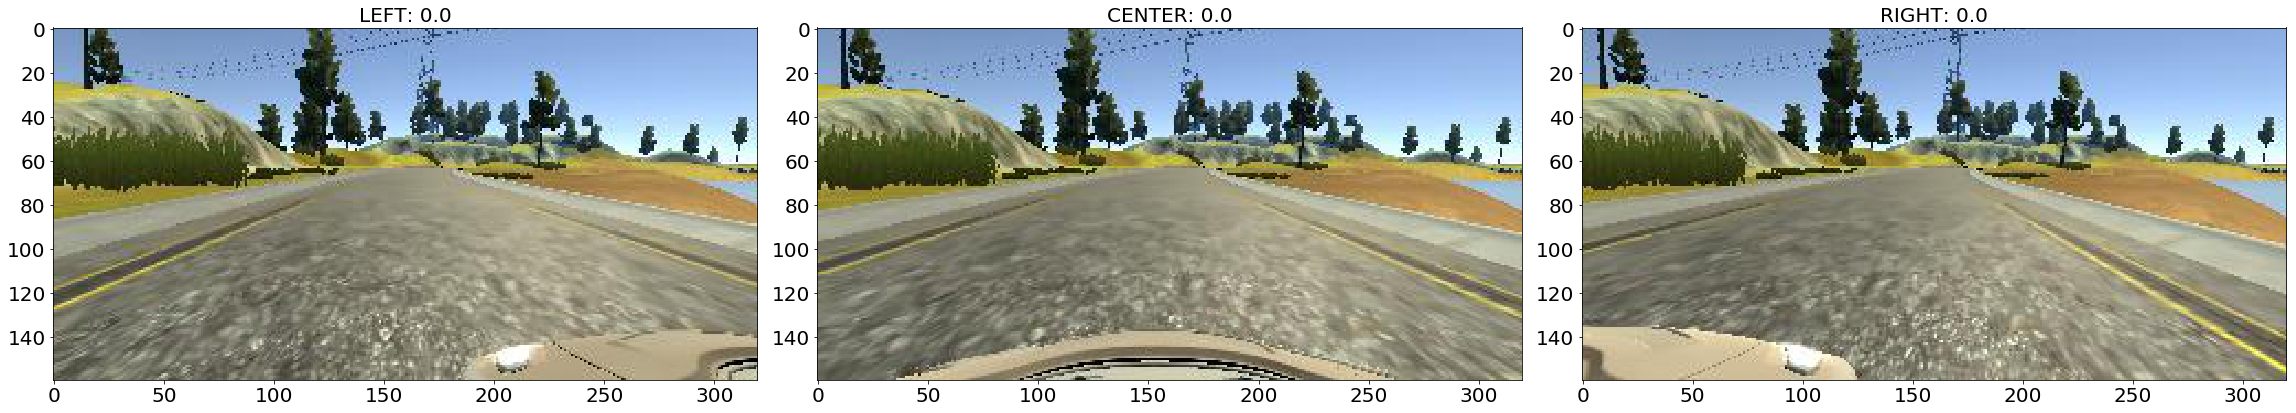

In [4]:
####################################################################
## Visualize left, center and right angle camera at the same moment
####################################################################
chk_idx =int(np.random.uniform(1, len(df)))
# print(chk_idx)
img_left = cv2.imread(data_dir+df["left_image"][chk_idx].strip())
img_left = cv2.cvtColor(img_left, cv2.COLOR_BGR2RGB)
img_center = cv2.imread(data_dir+df["center_image"][chk_idx].strip())
img_center = cv2.cvtColor(img_center, cv2.COLOR_BGR2RGB)
img_right = cv2.imread(data_dir+df["right_image"][chk_idx].strip())
img_right = cv2.cvtColor(img_right, cv2.COLOR_BGR2RGB)
angle = df["steering_angle"][chk_idx]
plt.rcParams["figure.figsize"] = [32, 24]
plt.tick_params(axis='x', labelsize=25)

plt.subplot(1, 3, 1)
plt.imshow(img_left)
plt.title("LEFT: " + str(np.round(angle, 2)), fontsize=20)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)

plt.subplot(1, 3, 2)
plt.imshow(img_center)
plt.title("CENTER: " + str(np.round(angle, 2)), fontsize=20)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)

plt.subplot(1, 3, 3)
plt.imshow(img_right)
plt.title("RIGHT: " + str(np.round(angle, 2)), fontsize=20)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)

plt.tight_layout()
plt.show()

### Data Discovery and Analysis

imgage shape: (160, 320, 3)
min angle:  -0.9426954
max angle:  1.0
avg_samples_per_bin:  1000


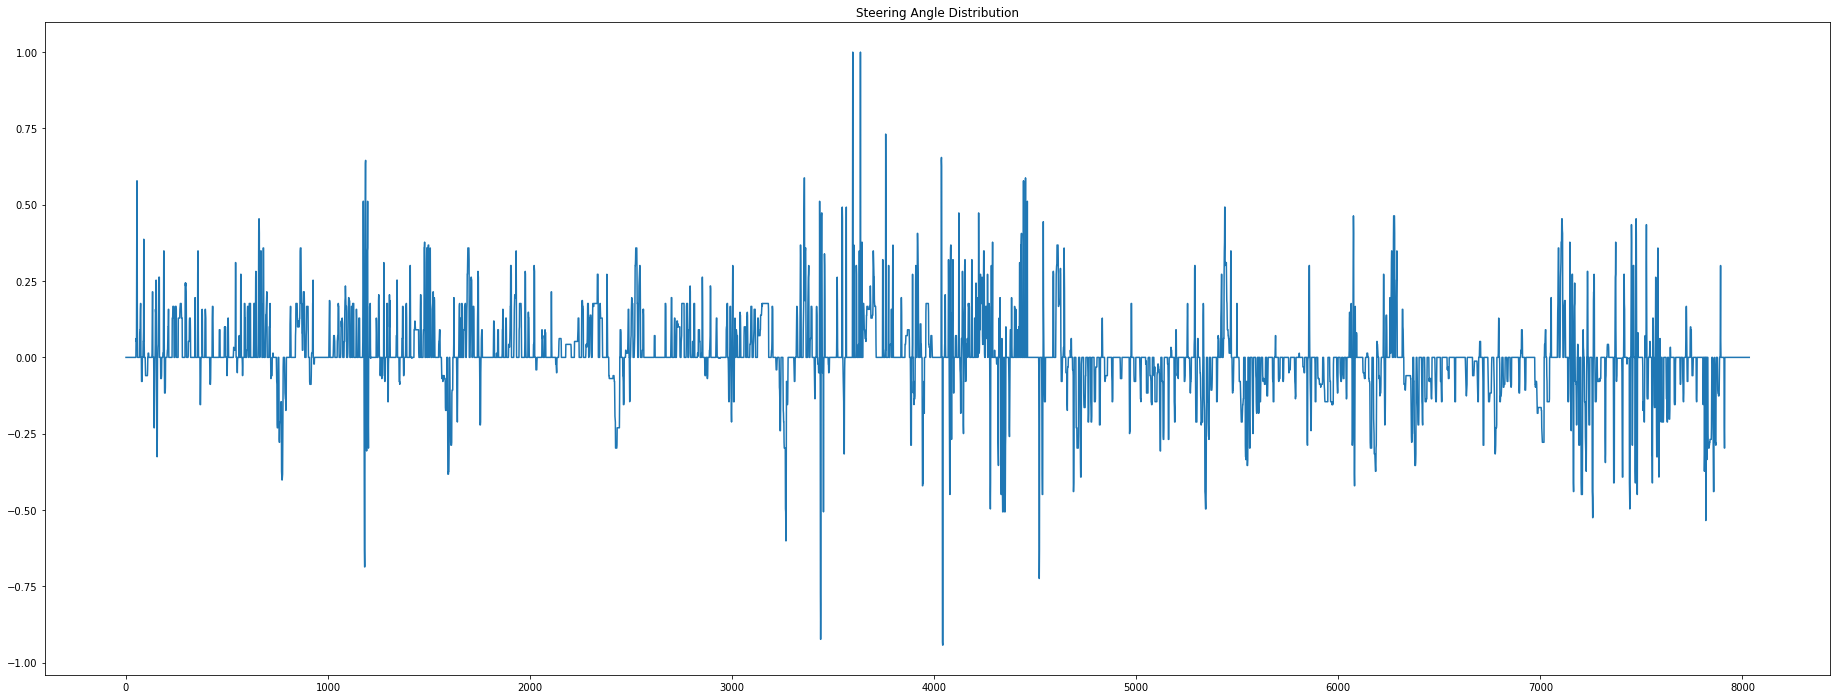

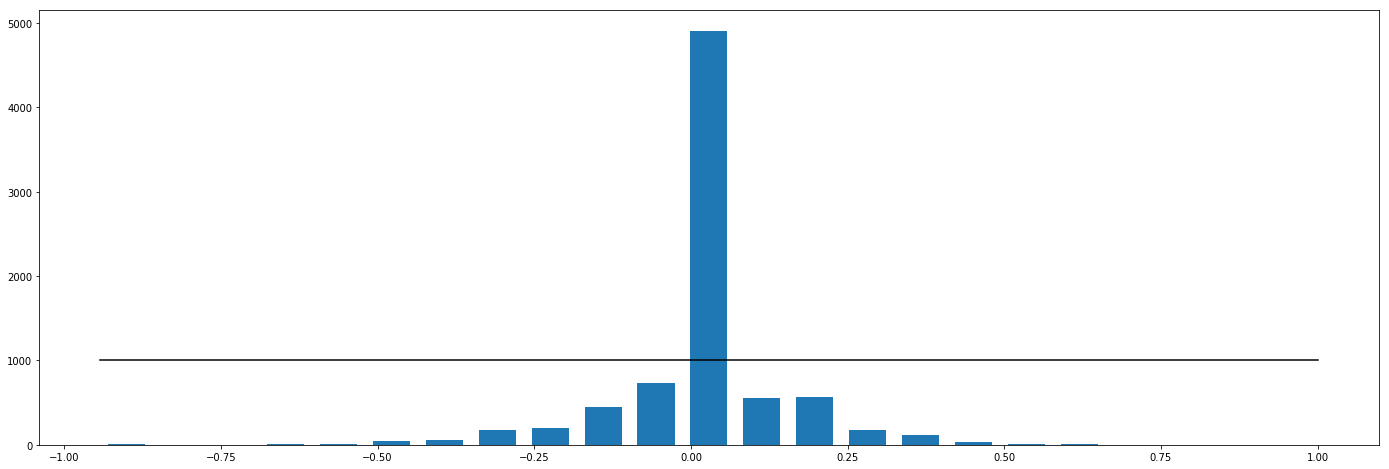

In [5]:
# This is a 160 pixel x 320 pixel x 3 channels
print("imgage shape:", img_center.shape)

min_angle = np.min(df["steering_angle"])
max_angle = np.max(df["steering_angle"])
print('min angle: ', min_angle)
print('max angle: ', max_angle)

# Time Series plot of steering angles
plt.rcParams["figure.figsize"] = [24, 12]
plt.figure(figsize=(32,12))
plt.title("Steering Angle Distribution")
ts = df["steering_angle"]
plt.plot(ts)

# plt.figure(figsize=(32,12))
# plt.hist(ts.astype('float'), bins=np.arange(-1.0, 1.0, 0.075))
# plt.title("Steering Angle Histogram")
# plt.show()

# bins = np.arange(-1.0, 1.0, 0.05)
# hist, bin_edges = np.histogram(df["steering_angle"], bins=bins)
# Create Steering Angle Bin Counts  
# steer_bin = []
# for i in range(len(hist)):
#     steer_bin.append([bins[i], bins[i+1], hist[i]])
    
# Examine Steering Angle Bin Counts
# steer_bin

# print a histogram to see which steering angle ranges are most overrepresented
num_bins = 23
avg_samples_per_bin = 1000 #len(df["steering_angle"])/num_bins
print('avg_samples_per_bin: ', avg_samples_per_bin)
hist, bins = np.histogram(df["steering_angle"], num_bins)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.figure(figsize=(24,8))
plt.bar(center, hist, align='center', width=width)
plt.plot((np.min(df["steering_angle"]), np.max(df["steering_angle"])), (avg_samples_per_bin, avg_samples_per_bin), 'k-')
plt.show()

### Data Augmentation and Balancing

In [6]:
# # determine keep probability for each bin: if below avg_samples_per_bin, keep all; otherwise keep prob is proportional
# # to number of samples above the average, so as to bring the number of samples for that bin down to the average
# keep_probs = []
# target = avg_samples_per_bin #* .5
# for i in range(num_bins):
#     if hist[i] < target:
#         keep_probs.append(1.)
#     else:
#         keep_probs.append(target/(hist[i]))
# remove_list = []
# for i in range(len(df["steering_angle"])):
#     for j in range(num_bins):
#         if df["steering_angle"][i] > bins[j] and df["steering_angle"][i] <= bins[j+1]:
#             # delete from X and y with probability 1 - keep_probs[j]
#             if np.random.rand() > keep_probs[j]:
#                 remove_list.append(i)
                
# df.drop(remove_list, inplace=True)
# df = df.reset_index(drop=True)

# # print histogram again to show more even distribution of steering angles
# hist, bins = np.histogram(df["steering_angle"], num_bins)
# plt.bar(center, hist, align='center', width=width)
# plt.plot((np.min(df["steering_angle"]), np.max(df["steering_angle"])), (avg_samples_per_bin, avg_samples_per_bin), 'k-')
# plt.show()


# Take a look at https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

# df_right = []
# df_left = []
# df_center = []
# for i in range(len(df)):
#     center_img = df["center_image"][i]
#     left_img = df["left_image"][i]
#     right_img = df["right_image"][i]
#     angle = df["steering_angle"][i]

#     if (angle > 0.1):
#         df_right.append([center_img, left_img, right_img, angle]) 
#         #reducing the samples with angles ranging between .15 and .2
# #         if(angle < .15)or(angle >.2):
#             # I'm adding a small deviation of the angle 
#             # This is to create more right turning samples for the same image
#         for i in range(5):
#             new_angle = angle * (1.0 + np.random.uniform(-1, 1)/30.0)
#             df_right.append([center_img, left_img, right_img, new_angle])
            
#     elif (angle < -0.1):
#     if (angle < -0.):
#         df_left.append([center_img, left_img, right_img, angle])
        
#         # I'm adding a small deviation of the angle
#         # This is to create more left turning samples for the same image
#         for i in range(5):
#             new_angle = angle * (1.0 + np.random.uniform(-1, 1)/30.0)
#             df_left.append([center_img, left_img, right_img, new_angle])
            
#     else:
#     if (angle != 0.0):
#     # Include all near 0 angle data
#         df_center.append([center_img, left_img, right_img, angle])            
#     else:
#         if np.random.uniform()>= 0.9: 
#             df_center.append([center_img, left_img, right_img, angle])
        
        

# print(len(df_center), len(df_left), len(df_right))

In [7]:
# Shuffle the data so they're no longer sequential in the order that the data was collected
# random.shuffle(df_center)
# random.shuffle(df_left)
# random.shuffle(df_right)
# df_center = pd.DataFrame(df_center, columns=["center_image", "left_image", "right_image", "steering_angle"])
# df_left = pd.DataFrame(df_left, columns=["center_image", "left_image", "right_image", "steering_angle"])
# df_right = pd.DataFrame(df_right, columns=["center_image", "left_image", "right_image", "steering_angle"])

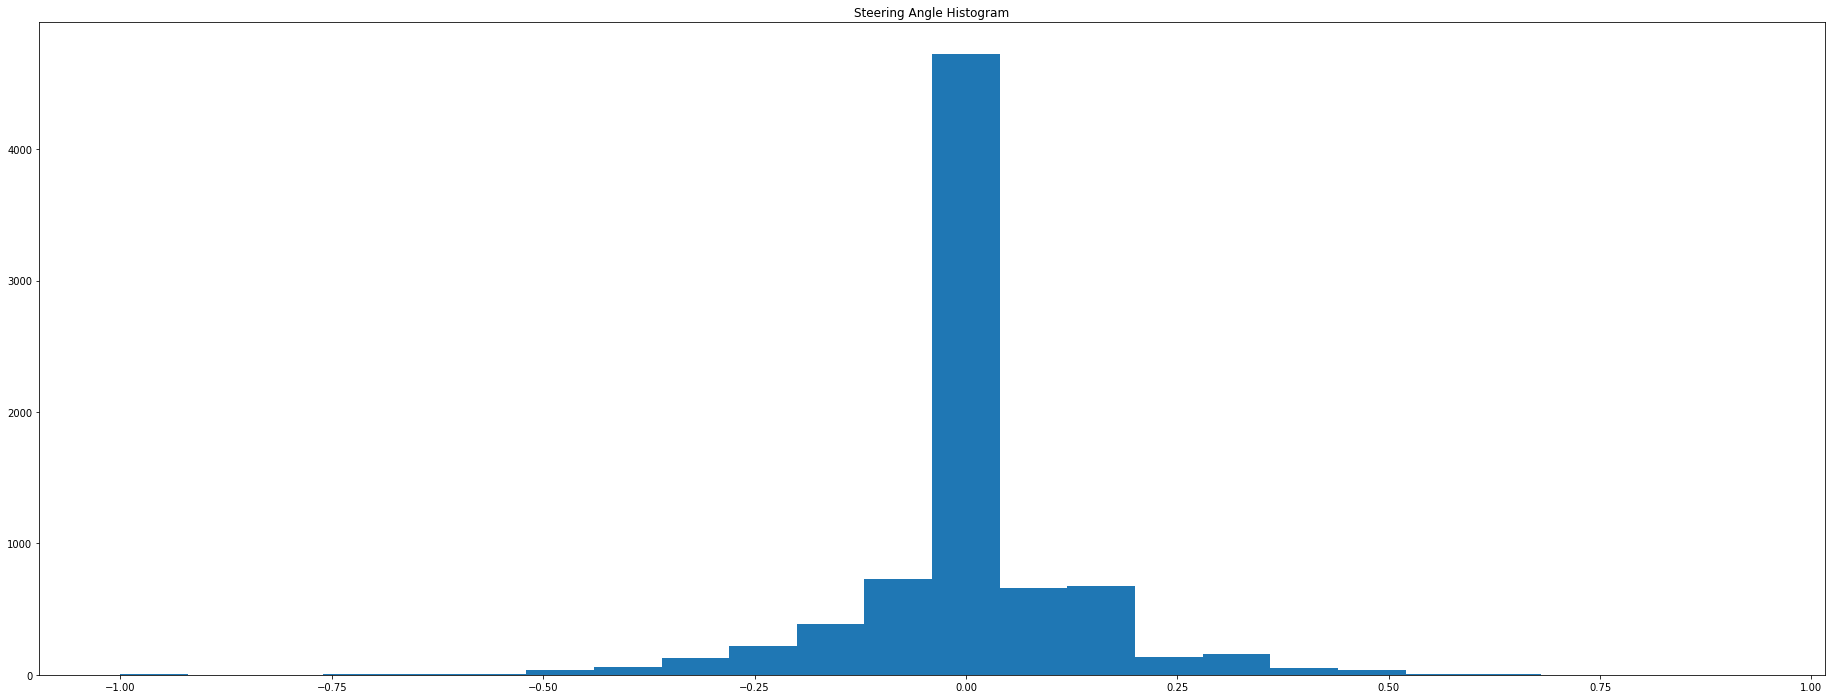

In [8]:
import pickle
# Make the train and valid list 
# data_list = [df_center, df_left, df_right]
# data_list_df = pd.concat(data_list, ignore_index=True)
data_list_df = df
len(data_list_df)
data_list_df.to_pickle('data.pickle')

# histogram after data augmentation
ts = data_list_df["steering_angle"]
plt.figure(figsize=(32,12))
plt.hist(ts.astype('float'), bins=np.arange(-1.0, 1.0, 0.08))
plt.title("Steering Angle Histogram")
plt.show()

bins = np.arange(-1.0, 1.0, 0.05)
hist, bin_edges = np.histogram(df["steering_angle"], bins=bins)
# Create Steering Angle Bin Counts  
# steer_bin = []
# for i in range(len(hist)):
#     steer_bin.append([bins[i], bins[i+1], hist[i]])

### 1. Perspective Transformation

In [9]:
def warp_img(img, angle):
    '''
    Warp image horizontally, calculate the angle shifted then append to orig angle.
    '''
    WARP_DIV_RATIO = 5

    rows,cols,ch = img.shape
    
    # shifts within 1/(WARP_DIV_RATIO) of image width
    shifted_pixel = random.randint(-1*cols//WARP_DIV_RATIO,cols//WARP_DIV_RATIO)
    
    pts1 = np.float32([[cols//2,0],[0,rows-1],[cols-1,rows-1]])
    pts2 = np.float32([[cols//2+shifted_pixel,0],[0,rows-1],[cols-1,rows-1]])
    
    delta_angle = 0.004*shifted_pixel
    total_angle = angle + delta_angle
    #print(delta_angle, total_angle)
    
    M = cv2.getAffineTransform(pts1,pts2)
    warp_img = cv2.warpAffine(img,M,(cols,rows))
    #cv2.imwrite('test.png', img)
    #cv2.imwrite('test_warp.png', warp_img)
    return warp_img, total_angle


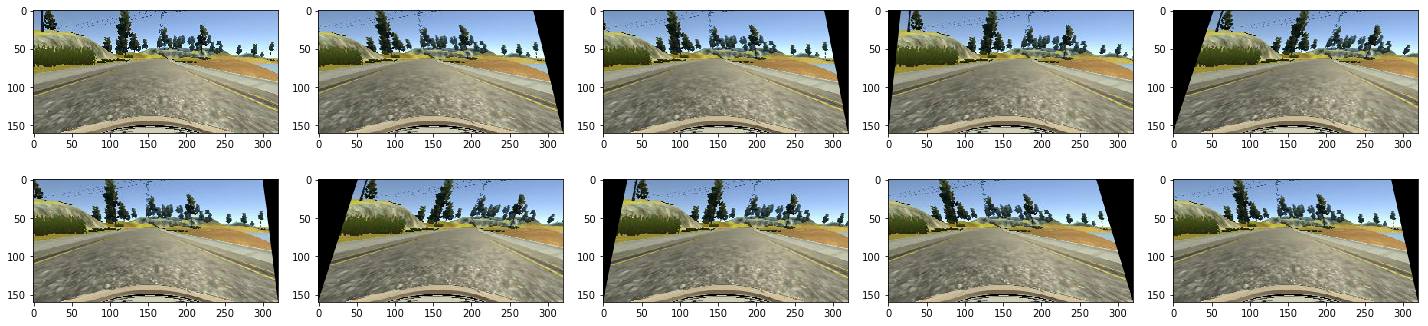

In [10]:
plt.rcParams["figure.figsize"] = [20, 5]
for i in range(0, 10):
    plt.subplot(2, 5, i+1) 
    plt.tight_layout()
    if i == 0:
        plt.imshow(img_center) 
    else:
        img, new_angle = warp_img(img_center, 0.1)
        plt.imshow(img)

### 2. Brightness Augmentation

In [11]:
def augment_brightness(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = .25+np.random.uniform()
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

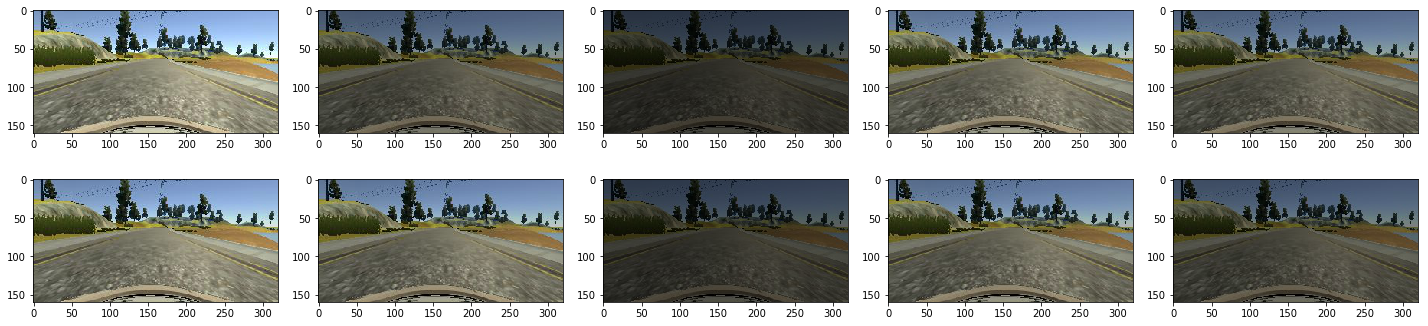

In [12]:
# Visaulize augment_brightness
plt.rcParams["figure.figsize"] = [20, 5]
for i in range(0, 10):
    plt.subplot(2, 5, i+1) 
    plt.tight_layout()
    if i == 0:
        plt.imshow(img_center) 
    else:
        img = augment_brightness(img_center)
        plt.imshow(img)

### 3. Image Tranlation

In [13]:
def trans_image(image,steer,trans_range, trans_y=False):
    """
    translate image and compensate for the translation on the steering angle
    """  
    rows, cols, chan = image.shape
    
    # horizontal translation with 0.008 steering compensation per pixel
    tr_x = trans_range*np.random.uniform()-trans_range/2
    steer_ang = steer + tr_x/trans_range*2*.2
    
    # option to disable vertical translation (vertical translation not necessary)
    if trans_y:
        tr_y = 40*np.random.uniform()-40/2
    else:
        tr_y = 0
    
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])
    image_tr = cv2.warpAffine(image,Trans_M,(cols,rows))
    
    return image_tr,steer_ang

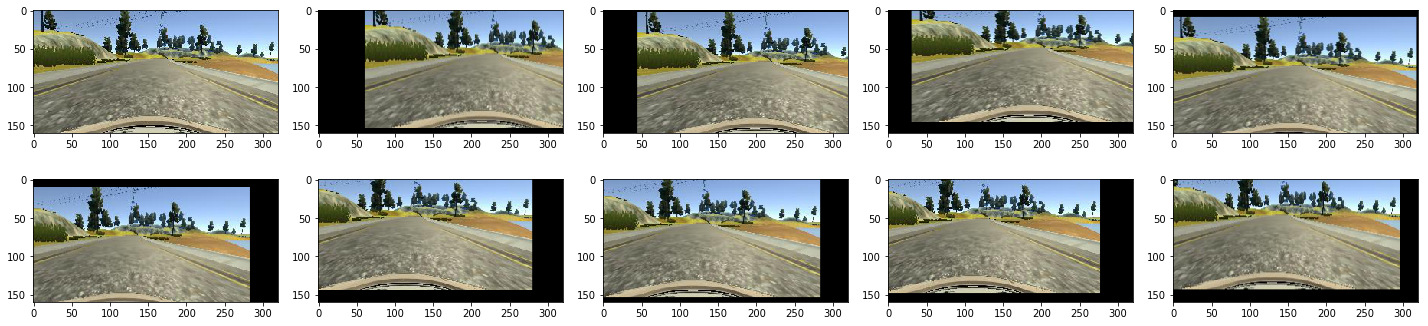

In [14]:
## Visualize Image Tranlation
plt.rcParams["figure.figsize"] = [20, 5]
for i in range(0, 10):
    plt.subplot(2, 5, i+1) 
    plt.tight_layout()
    if i == 0:
        plt.imshow(img_center) 
    else:
        img, new_angle = trans_image(img_center, 0.1, 150, True)
        plt.imshow(img)

### 4. Random Flipping

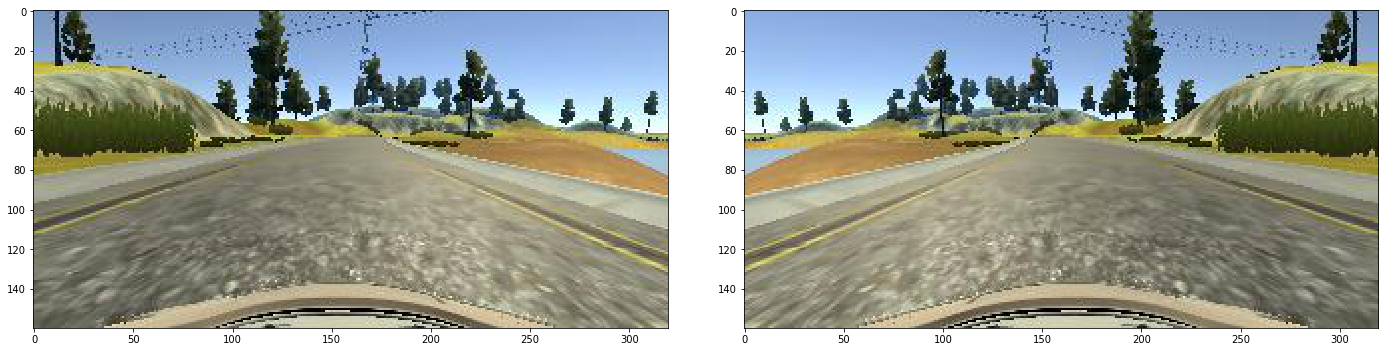

In [15]:
## Visualize Image Tranlation
plt.rcParams["figure.figsize"] = [20, 5]
for i in range(0, 2):
    plt.subplot(1, 2, i+1) 
    plt.tight_layout()
    if i == 0:
        plt.imshow(img_center) 
    else:
        img = cv2.flip(img_center, 1)
        plt.imshow(img)    

### 5. Random Shadow

In [16]:
# Below func. copied from: https://chatbotslife.com/using-augmentation-to-mimic-human-driving-496b569760a9#.kgjn97cup
def add_random_shadow(image):
    top_y = image.shape[1]*np.random.uniform()
    top_x = 0
    bot_x = image.shape[0]
    bot_y = image.shape[1]*np.random.uniform()
    image_hls = cv2.cvtColor(image,cv2.COLOR_RGB2HLS)
    shadow_mask = 0*image_hls[:,:,1]
    X_m = np.mgrid[0:image.shape[0],0:image.shape[1]][0]
    Y_m = np.mgrid[0:image.shape[0],0:image.shape[1]][1]
    
    shadow_mask[((X_m-top_x)*(bot_y-top_y) -(bot_x - top_x)*(Y_m-top_y) >=0)]=1
    random_bright = .15+.8*np.random.uniform()
    if np.random.randint(2)==1:
    #    random_bright = .5
        cond1 = shadow_mask==1
        cond0 = shadow_mask==0
        if np.random.randint(2)==1:
            image_hls[:,:,1][cond1] = image_hls[:,:,1][cond1]*random_bright
        else:
            image_hls[:,:,1][cond0] = image_hls[:,:,1][cond0]*random_bright    
    image = cv2.cvtColor(image_hls,cv2.COLOR_HLS2RGB)
    return image


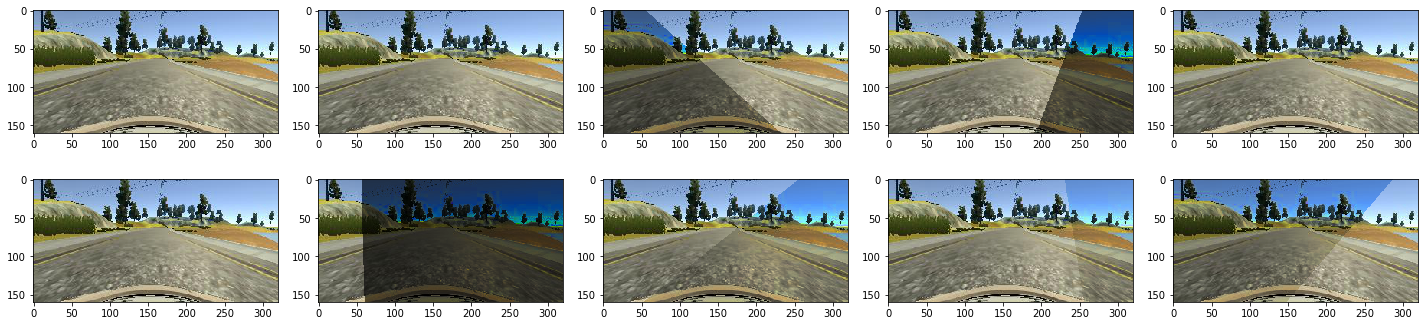

In [17]:
plt.rcParams["figure.figsize"] = [20, 5]
for i in range(0, 10):
    plt.subplot(2, 5, i+1) 
    plt.tight_layout()
    if i == 0:
        plt.imshow(img_center) 
    else:
        img = add_random_shadow(img_center)
        plt.imshow(img)    

## Image Preprocessing Pipeline

In [18]:
# y_data is not used as it is already contained in X_data's column
# but I made it to conform to the train_test_split function format
X_data = data_list_df[["center_image","left_image","right_image","steering_angle"]]
y_data = data_list_df["steering_angle"]

X_data = pd.DataFrame(X_data, columns=["center_image", "left_image", "right_image", "steering_angle"])
y_data = pd.DataFrame(y_data, columns=["steering_angle"])
X_train_data, X_valid_data, y_train_data, y_valid_data = train_test_split(X_data, y_data, test_size=0.2)

# Resets the row index
X_train_data = X_train_data.reset_index(drop=True)
X_valid_data = X_valid_data.reset_index(drop=True)
# X_train_data[0:5]
print(len(X_train_data), len(X_valid_data))

6428 1607


In [19]:
def crop_image(image, y1, y2, x1, x2):
    """
    crop image into respective size
    give: the crop extent
    """
    return image[y1:y2, x1:x2]

def img_preprocess(image, steer_ang, train=True):
    """
    Apply processing to image
    """    
    # image size
    im_y = image.shape[0]
    im_x = image.shape[1]
    
    trans_range = 50 #150
    isWarp = False
    
    if train == True:
        # translate image and compensate for steering angle
#         image, steer_ang = trans_image(image, steer_ang, trans_range) # , trans_y=True
    
        if np.random.uniform()>= 0.5:# and abs(steer_ang) > 0.1
            image, steer_ang= warp_img(image, steer_ang)            
            # crop image region of interest
            image = crop_image(image, 20, 140, 0+trans_range, im_x-trans_range)
        else:
            image = crop_image(image, 20, 140, 0, im_x)            
    
        # flip image (randomly)
        if np.random.uniform()>= 0.5 and abs(steer_ang) > 0.1:
            image = cv2.flip(image, 1)
            steer_ang = -1.0*steer_ang

        # augment brightness
        image = augment_brightness(image)

        # random shadow:
    #     image = add_random_shadow(image)
    
    return image, steer_ang

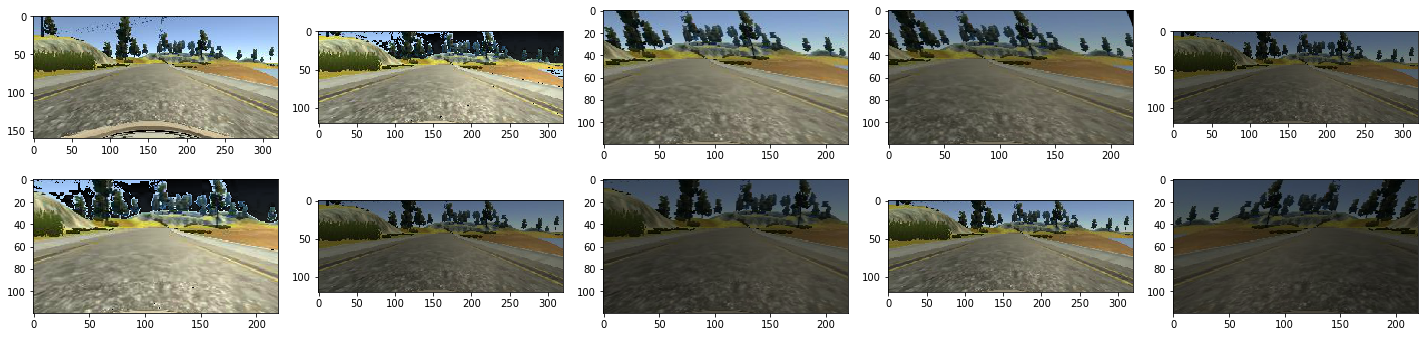

In [20]:
# Visualize preprocessing
plt.rcParams["figure.figsize"] = [20, 5]
for i in range(0, 10):
    plt.subplot(2, 5, i+1) 
    plt.tight_layout()
    if i == 0:
        plt.imshow(img_center) 
    else:
        img, new_angle = img_preprocess(img_center, 0.1)
        plt.imshow(img)

(66, 200, 3)


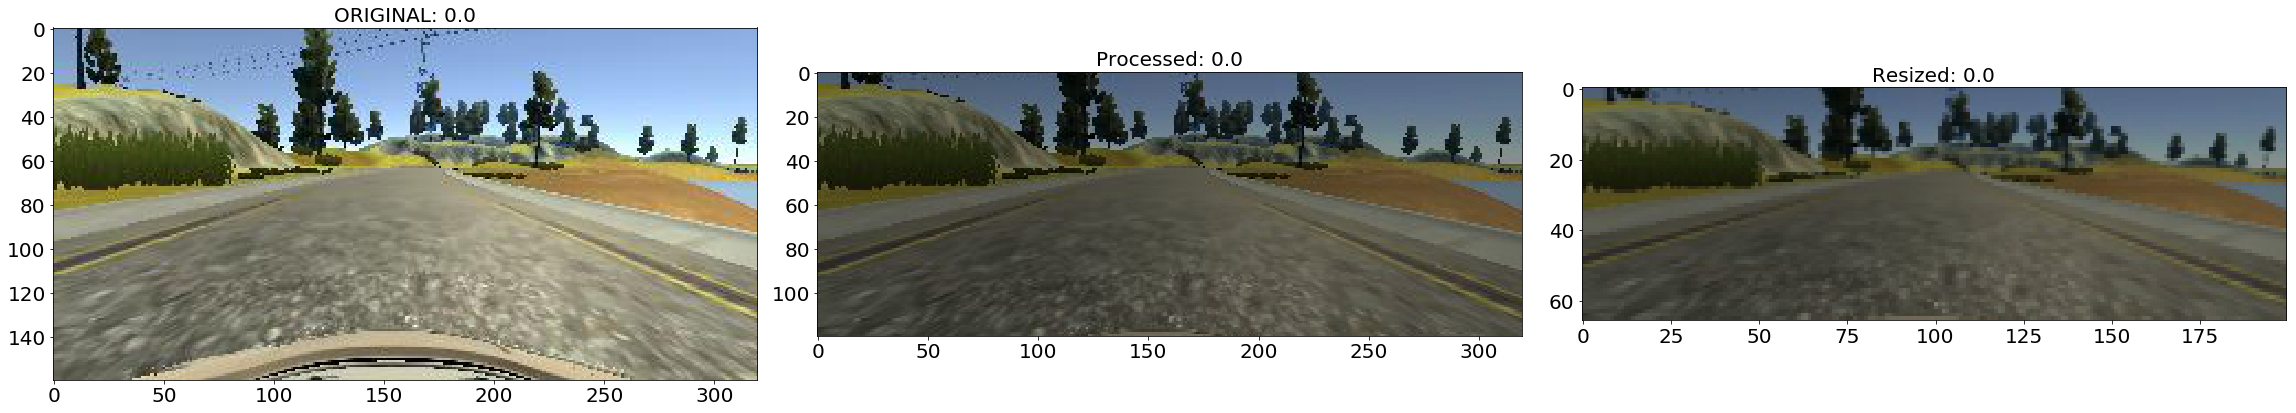

In [28]:
## Visualize preprocessed data
row, col, ch = img_center.shape
img_center = img_center.reshape(row, col, ch)
img_center_processed, angle_processed = img_preprocess(img_center, angle)
img_center_resized = cv2.resize(img_center_processed, (200,66), interpolation=cv2.INTER_AREA)
print(img_center_resized.shape)

plt.rcParams["figure.figsize"] = [32, 24]
plt.tick_params(axis='x', labelsize=25)
plt.subplot(1, 3, 1)
plt.imshow(img_center)
plt.title("ORIGINAL: " + str(np.round(angle, 2)), fontsize=20)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)

plt.subplot(1, 3, 2)
plt.imshow(img_center_processed)
plt.title("Processed: " + str(np.round(angle_processed, 2)), fontsize=20)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)

plt.subplot(1, 3, 3)
plt.imshow(img_center_resized)
plt.title("Resized: " + str(np.round(angle_processed, 2)), fontsize=20)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.tight_layout()
plt.show()

## Create the model

### Create the generator

In [22]:
_index_in_epoch = 0
batch_size = 64
img_height, img_width = 160, 320

####################################################################
def shuffle(x, y):
    perm = np.arange(len(x))
    np.random.shuffle(perm)
    x = x[perm]
    y = y[perm]

    return (x, y)

def load_training_and_validation_from_dataframe(df):
    rows, labels = [], []
    correction = 0.25 # this is a parameter to tune

    for idx in range(len(df)):
        angle = df['steering_angle'][idx]

        ## left image
        img_path = df['left_image'][idx]
        labels.append(angle + correction)
        rows.append(img_path)

        ## centre image
        img_path = df['center_image'][idx]
        labels.append(angle)
        rows.append(img_path)

        ## right image
        img_path = df['right_image'][idx]
        labels.append(angle - correction)
        rows.append(img_path)

    assert len(rows) == len(labels), 'unbalanced data'

    # shuffle the data
    X, Y = shuffle(np.array(rows), np.array(labels))

    # split into training and validation
    return train_test_split(X, Y, test_size = .25)

In [23]:
####################################################################

def next_batch(data, labels, batch_size):
    """
    Return the next `batch_size` examples from this data set.
    """
    global _index_in_epoch
    start = _index_in_epoch
    _index_in_epoch += batch_size
    _num_examples = len(data)

    if _index_in_epoch > _num_examples:
        # Shuffle the data
        data, labels = shuffle(data, labels)
        # Start next epoch
        start = 0
        _index_in_epoch = batch_size
        assert batch_size <= _num_examples

    end = _index_in_epoch
    return data[start:end], labels[start:end]

####################################################################

def transform_generator(x, y, batch_size, is_validation=False):
    while True:
        bad = []
        images, labels = list(), list()
        _images, _labels = next_batch(x, y, batch_size)
        for i in range(len(_images)):
            img = cv2.imread('data2/'+_images[i])
            if img is None: continue
            else: bad.append('/home/sameh/short-p/data2/{}'.format(_images[i]))
            img = img.reshape(img_height, img_width, 3)
            angle = _labels[i]
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
         
            #pre-processing
            img, angle = img_preprocess(img, angle, is_validation)
            img = cv2.resize(img, (200,66))
            
            images.append(img)
            labels.append(angle)

        X = np.array(images, dtype=np.float64).reshape((-1, 66, 200, 3))
        Y = np.array(labels, dtype=np.float64)            
        yield (X, Y)

### Build Model

In [24]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers import Lambda
from keras.layers import Cropping2D
from keras.utils import np_utils

def gen_model(model_type = "nvidia"):
    model = Sequential()
    #data preprocessing: normalization
    model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(66,200,3)))
    
    if model_type == "lenet":
        #model.add(Cropping2D(cropping=((50,20), (0,0)), input_shape=(160,320,3)))
        model.add(Convolution2D(6,5,5,activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Convolution2D(6,5,5,activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Flatten())
        model.add(Dense(120))
        model.add(Dense(84))
        model.add(Dense(1))

    if model_type == 'nvidia':  
        keep_prob = 0.5
        #model.add(Cropping2D(cropping=((65,25),(1,1))), input_shape=(img_height,img_width,3))
        model.add(Convolution2D(24,5,5,subsample=(2,2),activation='relu'))
        Dropout(keep_prob)
        model.add(Convolution2D(36,5,5,subsample=(2,2),activation='relu'))
        Dropout(keep_prob)
        model.add(Convolution2D(48,5,5,subsample=(2,2),activation='relu'))
        Dropout(keep_prob)
        model.add(Convolution2D(64,3,3,activation='relu'))
        Dropout(keep_prob)
        model.add(Convolution2D(64,3,3,activation='relu'))
        Dropout(keep_prob)
        model.add(Flatten())
        # layer 5, fc
        model.add(Dense(1164))
        model.add(Activation('relu'))
        model.add(Dropout(keep_prob))
        # layer 6, fc
        model.add(Dense(100))
        model.add(Activation('relu'))
        model.add(Dropout(keep_prob))
        # layer 7, fc
        model.add(Dense(50))
        model.add(Activation('relu'))
        #model.add(Dropout(0.5))
        # layer 8, fc
        model.add(Dense(10))
        model.add(Activation('relu'))
        #model.add(Dropout(0.5))
        # layer output
        model.add(Dense(1))

    if model_type == 'nvidia_v2':
                # -------------------------------------
        # Cover of NVidia end-to-end network (widen conv layers)
        # -------------------------------------
        # layer 1, conv
        model.add(Convolution2D(36, 5, 5, subsample=(2,2), input_shape=(66, 200, 3)))
        model.add(Activation('relu'))
        # layer 2, conv
        model.add(Convolution2D(48, 5, 5, subsample=(2,2)))
        model.add(Activation('relu'))
        model.add(Dropout(0.5))
        # layer 3, conv
        model.add(Convolution2D(64, 5, 5, subsample=(2,2)))
        model.add(Activation('relu'))
        model.add(Dropout(0.5))
        # layer 4, conv
        model.add(Convolution2D(96, 3, 3))
        model.add(Activation('relu'))
        model.add(Dropout(0.5))
        # layer 5, conv
        model.add(Convolution2D(96, 3, 3))
        model.add(Activation('relu'))
        model.add(Dropout(0.5))
        # Flatten
        model.add(Flatten())
        # layer 5, fc
        model.add(Dense(1164))
        model.add(Activation('relu'))
        model.add(Dropout(0.5))
        # layer 6, fc
        model.add(Dense(100))
        model.add(Activation('relu'))
        model.add(Dropout(0.5))
        # layer 7, fc
        model.add(Dense(50))
        model.add(Activation('relu'))
        #model.add(Dropout(0.5))
        # layer 8, fc
        model.add(Dense(10))
        model.add(Activation('relu'))
        #model.add(Dropout(0.5))
        # layer output
        model.add(Dense(1))

    adam = Adam(lr=0.0001)
    model.compile(loss='mean_squared_error', optimizer=adam)
#     model.summary()
    return model

Using TensorFlow backend.


In [25]:
import time
nb_epoch = 1
batch_size = 64

start_time = time.time()
X_train, X_val, Y_train, Y_val = load_training_and_validation_from_dataframe(data_list_df) 

assert len(X_train) == len(Y_train), 'unbalanced training data'
assert len(X_val) == len(Y_val), 'unbalanced validation data'
print(len(X_train), "training images and ", len(X_val), "validation images")

model = gen_model(model_type='nvidia')

for i_pr in range(5):
    history = model.fit_generator(
        transform_generator(X_train, Y_train, batch_size = batch_size),
        samples_per_epoch=(len(X_train)),
        nb_epoch=nb_epoch,
        validation_data=transform_generator(X_val, Y_val, batch_size = batch_size, is_validation=True),
        nb_val_samples=len(X_val),
        verbose=1)

    model.save('model_' + str(i_pr)+ '.h5')
    val_loss = history.history['val_loss'][0]

print("--- execution time %s seconds ---" % (time.time() - start_time))


18078 training images and  6027 validation images
Epoch 1/1
18048/18078 [============================>.] - ETA: 0s - loss: 0.0316

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


18112/18078 [==============================] - 38s - loss: 0.0316 - val_loss: 0.0495
Epoch 1/1
18112/18078 [==============================] - 37s - loss: 0.0130 - val_loss: 0.0502
Epoch 1/1
18112/18078 [==============================] - 37s - loss: 0.0113 - val_loss: 0.0481
Epoch 1/1
18112/18078 [==============================] - 37s - loss: 0.0103 - val_loss: 0.0494
Epoch 1/1
18112/18078 [==============================] - 37s - loss: 0.0096 - val_loss: 0.0479
--- execution time 190.1074481010437 seconds ---
